# 1. Standard (not graph) AE + GNN for node classification from AE codings

## 

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
from utils import *

# Load the Fashion-MNIST dataset
def load_fmnist():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
    return train_dataset

# Convert images to feature vectors
def preprocess_data(dataset):
    data = dataset.data.numpy()
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1) / 255.0
    labels = dataset.targets.numpy()
    return data, labels

# Create a KNN graph
def create_knn_graph(data, k):
    knn_graph = kneighbors_graph(data, k, mode='connectivity', include_self=False)
    return knn_graph

# Convert the sparse matrix to edge_index format for PyTorch Geometric
def convert_to_torch_geometric_graph(knn_graph):
    coo = coo_matrix(knn_graph)
    edge_index = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long)
    return edge_index

# Main function to execute the steps
def main():
    # Load and preprocess the data
    train_dataset = load_fmnist()
    x_train, y_train = preprocess_data(train_dataset)
    
    # Use a subset of the data for simplicity (e.g., first 1000 samples)
    x_subset = x_train[:1000]
    y_subset = y_train[:1000]
    
    # Create KNN graph
    k = 2  # Number of neighbors
    knn_graph = create_knn_graph(x_subset, k)
    
    # Convert to PyTorch Geometric Data object
    edge_index = convert_to_torch_geometric_graph(knn_graph)
    x = torch.tensor(x_subset, dtype=torch.float)
    y = torch.tensor(y_subset, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Set additional attributes for compatibility
    data.num_node_features = data.x.shape[1]
    data.num_classes = len(torch.unique(data.y))
    data.num_features = data.num_node_features
    
    # Print the Data object to verify
    print(data)
    print(f"Number of node features: {data.num_node_features}")
    print(f"Number of classes: {data.num_classes}")
    print(f"Number of features: {data.num_features}")
    
    return data



data = main()
generate_train_test(data)

# # Load the Cora dataset
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

Data(x=[1000, 784], edge_index=[2, 2000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



# Autoencoder Settings
input_dim = data.num_node_features
hidden_dim = 128
bottleneck_dim = 32
autoencoder = Autoencoder(input_dim, hidden_dim, bottleneck_dim)

# Training the Autoencoder
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
criterion_ae = nn.MSELoss()

for epoch in range(200):
    autoencoder.train()
    optimizer_ae.zero_grad()
    _, reconstructed = autoencoder(data.x)
    loss = criterion_ae(reconstructed, data.x)
    loss.backward()
    optimizer_ae.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Preparing the compressed features for the GNN
autoencoder.eval()
with torch.no_grad():  # Ensure no gradients are computed for the operation within this block
    compressed_features, _ = autoencoder(data.x)
    compressed_features = compressed_features.detach()  # Detach the features from the graph


# Training the GNN
gcn = GCN(bottleneck_dim, hidden_dim, data.num_classes)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01)
criterion_gcn = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    gcn.train()
    optimizer_gcn.zero_grad()
    out = gcn(compressed_features, data.edge_index)
    loss = criterion_gcn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gcn.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.17194214463233948
Epoch 10, Loss: 0.06455685198307037
Epoch 20, Loss: 0.046824775636196136
Epoch 30, Loss: 0.03856837749481201
Epoch 40, Loss: 0.03286530077457428
Epoch 50, Loss: 0.028289977461099625
Epoch 60, Loss: 0.02497592195868492
Epoch 70, Loss: 0.023348627611994743
Epoch 80, Loss: 0.022234264761209488
Epoch 90, Loss: 0.0215067807585001
Epoch 100, Loss: 0.020996691659092903
Epoch 110, Loss: 0.019961846992373466
Epoch 120, Loss: 0.019286422058939934
Epoch 130, Loss: 0.019372012466192245
Epoch 140, Loss: 0.018630802631378174
Epoch 150, Loss: 0.01829996146261692
Epoch 160, Loss: 0.018351564183831215
Epoch 170, Loss: 0.017641514539718628
Epoch 180, Loss: 0.01693589985370636
Epoch 190, Loss: 0.016443679109215736
Epoch 0, Loss: 4.49327278137207
Epoch 10, Loss: 1.3390464782714844
Epoch 20, Loss: 0.9060167074203491
Epoch 30, Loss: 0.8509084582328796
Epoch 40, Loss: 0.786437451839447
Epoch 50, Loss: 0.772386908531189
Epoch 60, Loss: 0.7588323354721069
Epoch 70, Loss: 0.73

In [3]:
# Switch model to evaluation mode
gcn.eval()

# No gradient calculation needed for evaluation
with torch.no_grad():
    # Forward pass with the test data
    test_out = gcn(compressed_features, data.edge_index)
    # Use the class with the highest probability as the prediction
    test_pred = test_out.argmax(dim=1)
    # Calculate the number of correct predictions in the test set
    correct = (test_pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    # Calculate the test accuracy
    test_accuracy = correct / data.test_mask.sum().item()




## 

In [4]:
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.79


This obviously does not work. Let's try to fix it.

# 2. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
2-dim output

## 

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 2
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 16

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    

/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3257185220718384
Epoch: 20, Loss: 1.3274176120758057
Epoch: 30, Loss: 1.3155276775360107
Epoch: 40, Loss: 1.3043010234832764
Epoch: 50, Loss: 1.289292812347412
Epoch: 60, Loss: 1.265674114227295
Epoch: 70, Loss: 1.2372691631317139
Epoch: 80, Loss: 1.2105636596679688
Epoch: 90, Loss: 1.1911633014678955
Epoch: 100, Loss: 1.1724408864974976
Epoch 0, Loss: 2.3415255546569824
Epoch 10, Loss: 2.1309850215911865
Epoch 20, Loss: 1.9354920387268066
Epoch 30, Loss: 1.8024972677230835
Epoch 40, Loss: 1.7341032028198242
Epoch 50, Loss: 1.686282992362976
Epoch 60, Loss: 1.670637845993042
Epoch 70, Loss: 1.635054349899292
Epoch 80, Loss: 1.64373779296875
Epoch 90, Loss: 1.6247481107711792


## 

In [6]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.3050


# 3. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
16-dim output

## 

In [7]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 70000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 16
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 32

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.386364459991455
Epoch: 20, Loss: 1.386568307876587
Epoch: 30, Loss: 1.3866993188858032
Epoch: 40, Loss: 1.3867378234863281
Epoch: 50, Loss: 1.386725664138794
Epoch: 60, Loss: 1.386691927909851
Epoch: 70, Loss: 1.3866527080535889
Epoch: 80, Loss: 1.3866147994995117
Epoch: 90, Loss: 1.3865797519683838
Epoch: 100, Loss: 1.3865480422973633
Epoch 0, Loss: 2.304352045059204
Epoch 10, Loss: 2.2966675758361816
Epoch 20, Loss: 2.2950594425201416
Epoch 30, Loss: 2.291408061981201
Epoch 40, Loss: 2.284219741821289
Epoch 50, Loss: 2.283606767654419
Epoch 60, Loss: 2.285419464111328
Epoch 70, Loss: 2.2728655338287354
Epoch 80, Loss: 2.2720954418182373
Epoch 90, Loss: 2.267716407775879


## 

In [9]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1600


# 4. Basic Graph AE for DR
super basic 2 GCNConv layers  
2-dim output straight for visualisation

## 

In [10]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 70000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
import matplotlib.pyplot as plt

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.386298656463623
Epoch: 20, Loss: 1.3863073587417603
Epoch: 30, Loss: 1.38631272315979
Epoch: 40, Loss: 1.3863152265548706
Epoch: 50, Loss: 1.3863165378570557
Epoch: 60, Loss: 1.3863167762756348
Epoch: 70, Loss: 1.3863165378570557
Epoch: 80, Loss: 1.3863162994384766
Epoch: 90, Loss: 1.3863162994384766
Epoch: 100, Loss: 1.3863162994384766


## 

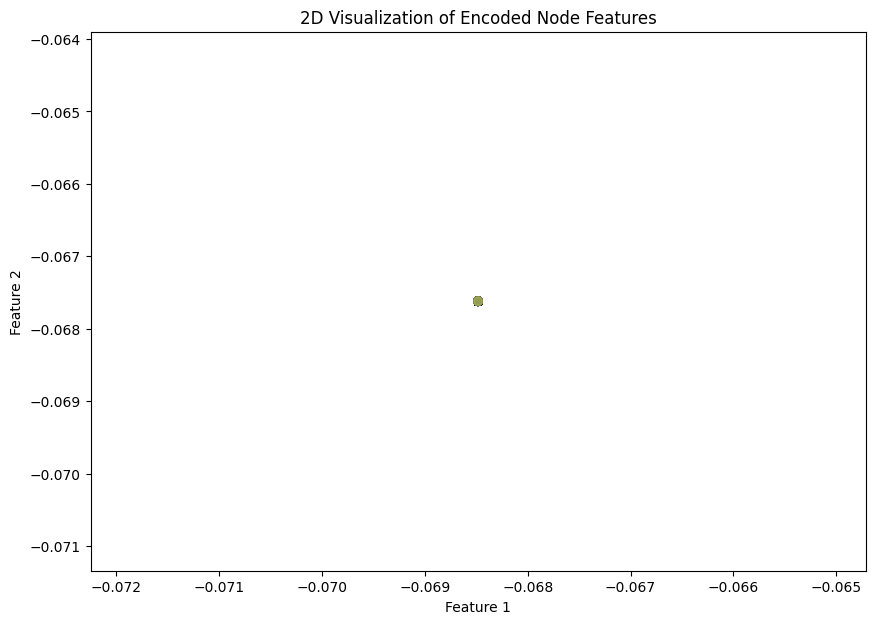

In [12]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 5. Basic Graph AE + tSNE
super basic 2 GCNConv layers  
16-dim output -> tSNE (2dim)

## 

In [13]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 70000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_features)



Epoch: 10, Loss: 34.53877258300781
Epoch: 20, Loss: 34.53877258300781
Epoch: 30, Loss: 34.53877258300781
Epoch: 40, Loss: 34.53877258300781
Epoch: 50, Loss: 34.53877258300781
Epoch: 60, Loss: 34.53877258300781
Epoch: 70, Loss: 34.53877258300781
Epoch: 80, Loss: 34.53877258300781
Epoch: 90, Loss: 34.53877258300781
Epoch: 100, Loss: 34.53877258300781
Epoch: 110, Loss: 34.53877258300781
Epoch: 120, Loss: 34.53877258300781
Epoch: 130, Loss: 34.53877258300781
Epoch: 140, Loss: 34.53877258300781
Epoch: 150, Loss: 34.53877258300781
Epoch: 160, Loss: 34.53877258300781
Epoch: 170, Loss: 34.53877258300781
Epoch: 180, Loss: 34.53877258300781
Epoch: 190, Loss: 34.53877258300781
Epoch: 200, Loss: 34.53877258300781


## 

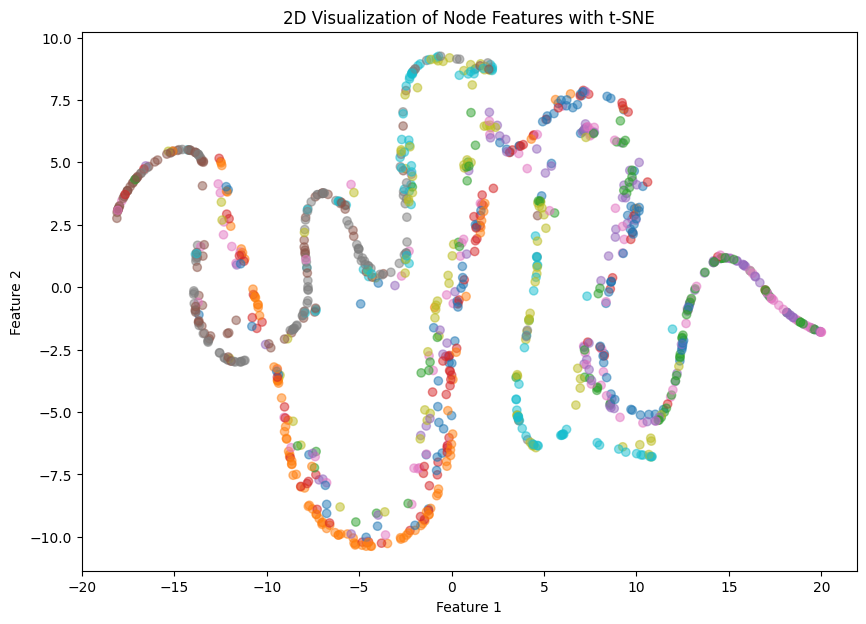

In [15]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 6. Graph AE with skip connections +tSNE
Three GCNConv layers with a skip connection

## 

In [16]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 70000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [17]:
class EnhancedGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedGCNEncoder, self).__init__()
        self.base_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.base_conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.skip_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)  # Skip connection
        self.conv3 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.base_conv1(x, edge_index))
        x = F.relu(self.base_conv2(x + skip1, edge_index))  # Combine with skip connection
        return self.conv3(x, edge_index)

# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.4568935632705688
Epoch: 20, Loss: 1.3847334384918213
Epoch: 30, Loss: 1.3223447799682617
Epoch: 40, Loss: 1.2013366222381592
Epoch: 50, Loss: 1.171242117881775
Epoch: 60, Loss: 1.163362741470337
Epoch: 70, Loss: 1.1446775197982788
Epoch: 80, Loss: 1.140486717224121
Epoch: 90, Loss: 1.1348882913589478
Epoch: 100, Loss: 1.128692626953125
Epoch: 110, Loss: 1.1341135501861572
Epoch: 120, Loss: 1.1270043849945068
Epoch: 130, Loss: 1.1191667318344116
Epoch: 140, Loss: 1.11246919631958
Epoch: 150, Loss: 1.1069395542144775
Epoch: 160, Loss: 1.098146915435791
Epoch: 170, Loss: 1.0891354084014893
Epoch: 180, Loss: 1.0898118019104004
Epoch: 190, Loss: 1.0648012161254883
Epoch: 200, Loss: 1.059058666229248


## 

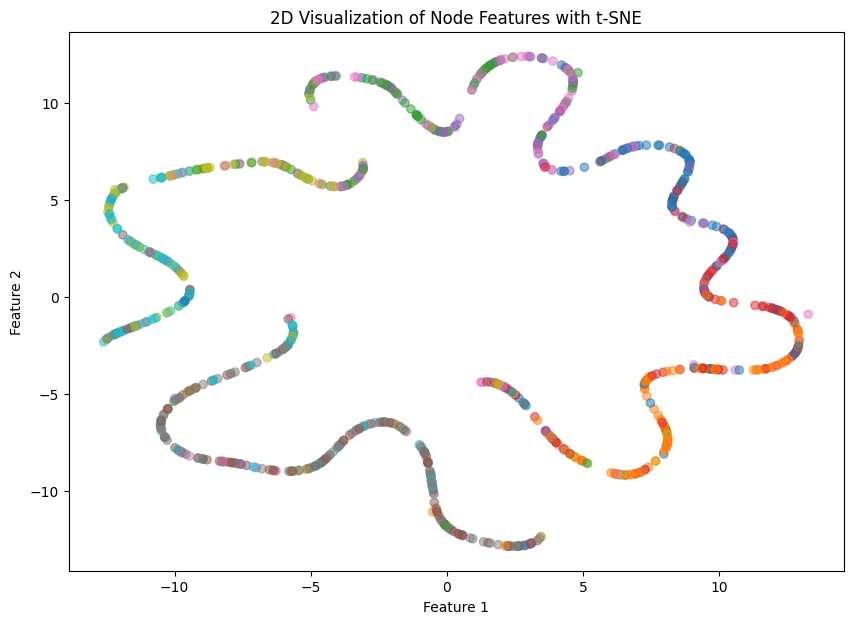

In [18]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 7. Graph AE with skip connections
Three GCNConv layers with a skip connection

## 

In [19]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 70000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [20]:
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.385972023010254
Epoch: 20, Loss: 1.384472131729126
Epoch: 30, Loss: 1.38414466381073
Epoch: 40, Loss: 1.3838129043579102
Epoch: 50, Loss: 1.3836852312088013
Epoch: 60, Loss: 1.3834877014160156
Epoch: 70, Loss: 1.383407711982727
Epoch: 80, Loss: 1.3831007480621338
Epoch: 90, Loss: 1.3830159902572632
Epoch: 100, Loss: 1.3826913833618164


## 

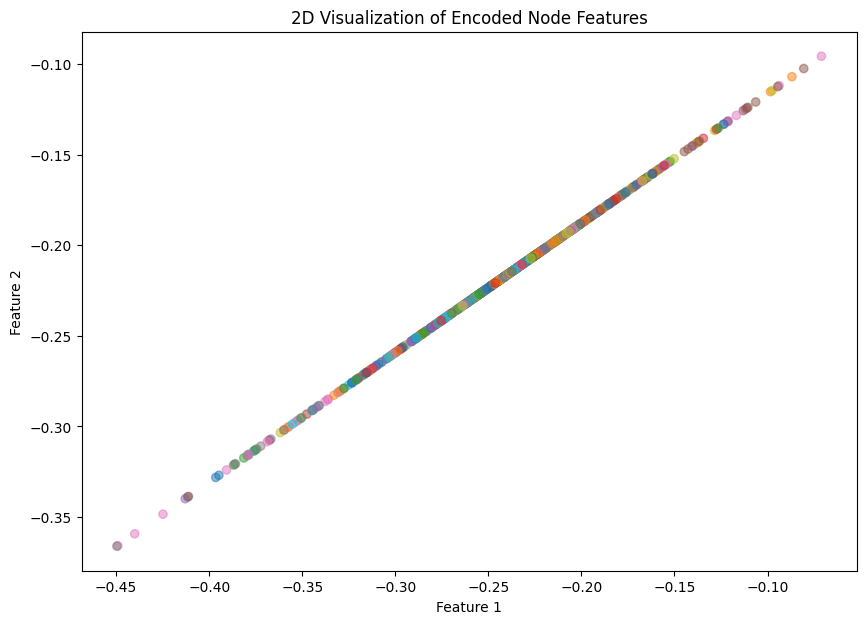

In [21]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')


# 8. Graph AE with attention
Two GATConv layers.

## 

In [22]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 70000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [23]:
from torch_geometric.nn import GATConv

class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=8, dropout=0.6)
        # Concatenate multi-head outputs so the final output will be 2*out_channels*8
        self.conv2 = GATConv(2 * out_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 32.76585006713867
Epoch: 20, Loss: 28.720069885253906
Epoch: 30, Loss: 16.302043914794922
Epoch: 40, Loss: 11.324837684631348
Epoch: 50, Loss: 9.820263862609863
Epoch: 60, Loss: 7.482100963592529
Epoch: 70, Loss: 7.521646976470947
Epoch: 80, Loss: 7.138750076293945
Epoch: 90, Loss: 7.523360252380371
Epoch: 100, Loss: 7.93568229675293
Epoch: 110, Loss: 6.982028961181641
Epoch: 120, Loss: 6.672497749328613
Epoch: 130, Loss: 8.172490119934082
Epoch: 140, Loss: 7.597316741943359
Epoch: 150, Loss: 7.242500305175781
Epoch: 160, Loss: 7.07727575302124
Epoch: 170, Loss: 7.347119331359863
Epoch: 180, Loss: 7.4503583908081055
Epoch: 190, Loss: 7.8135504722595215
Epoch: 200, Loss: 7.196484565734863


## 

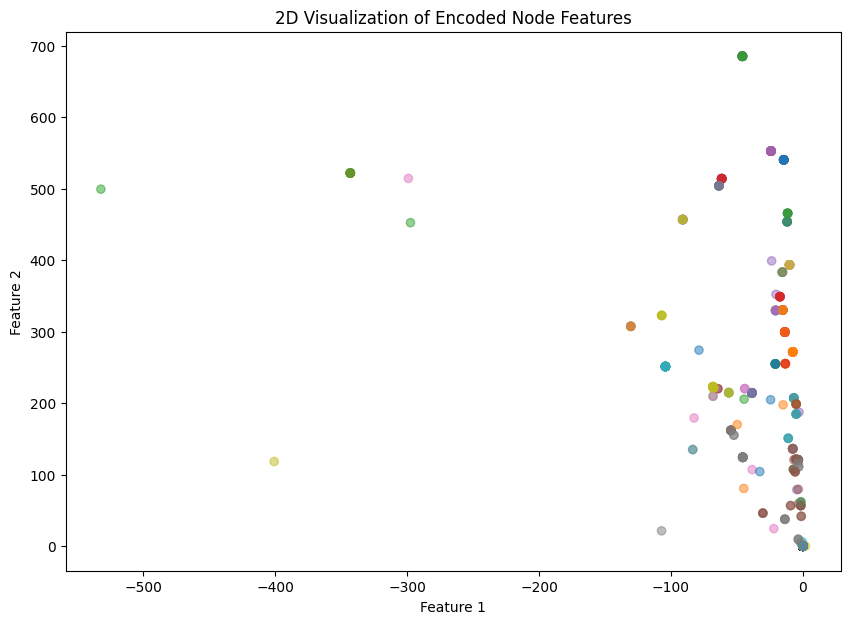

In [24]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 8. Graph AE with attention + tSNE
Two GATConv layers.

## 

In [25]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 70000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [26]:
# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()




Epoch: 10, Loss: 7.391866683959961
Epoch: 20, Loss: 6.756394863128662
Epoch: 30, Loss: 5.308506011962891
Epoch: 40, Loss: 5.533751964569092
Epoch: 50, Loss: 5.430792331695557
Epoch: 60, Loss: 6.137726306915283
Epoch: 70, Loss: 5.387476921081543
Epoch: 80, Loss: 5.663266181945801
Epoch: 90, Loss: 6.192282676696777
Epoch: 100, Loss: 5.3838114738464355
Epoch: 110, Loss: 5.704352855682373
Epoch: 120, Loss: 5.300031661987305
Epoch: 130, Loss: 5.3660664558410645
Epoch: 140, Loss: 5.787502288818359
Epoch: 150, Loss: 5.308566093444824
Epoch: 160, Loss: 6.406364917755127
Epoch: 170, Loss: 5.400051116943359
Epoch: 180, Loss: 5.9511332511901855
Epoch: 190, Loss: 4.6461286544799805
Epoch: 200, Loss: 5.345013618469238


## 

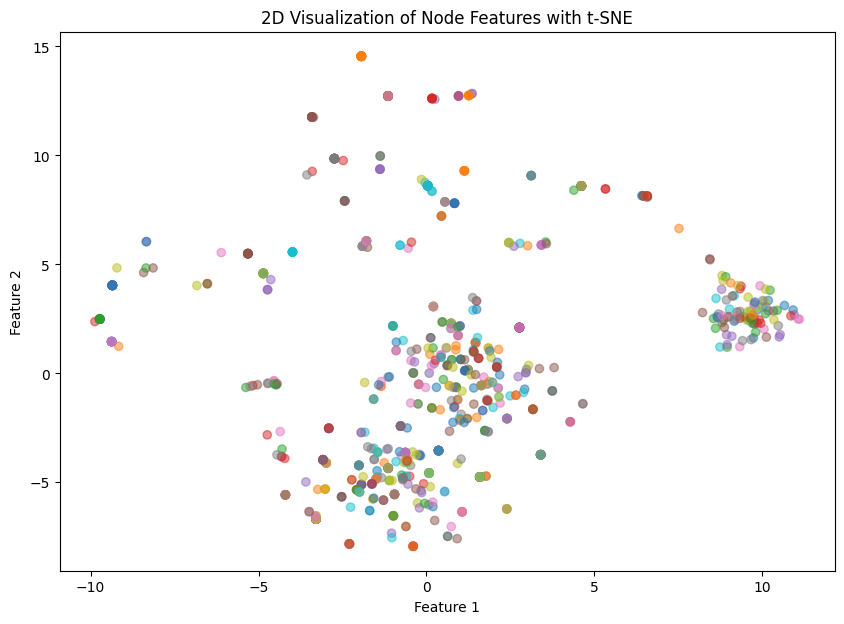

In [27]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 9. Graph AE with skip & residual connections
3 GCNConv layers with skip connections.

## 

In [28]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 70000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [29]:
class ComplexGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ComplexGCNEncoder, self).__init__()
        # Encoder with skip connections
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.skip_conv1 = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index)) + x  # Residual connection
        x = self.conv3(x, edge_index) + skip1  # Skip connection
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ComplexGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3181753158569336
Epoch: 20, Loss: 1.2730531692504883
Epoch: 30, Loss: 1.1364154815673828
Epoch: 40, Loss: 1.139517068862915
Epoch: 50, Loss: 1.125880479812622
Epoch: 60, Loss: 1.1224827766418457
Epoch: 70, Loss: 1.1259949207305908
Epoch: 80, Loss: 1.122408151626587
Epoch: 90, Loss: 1.122410535812378
Epoch: 100, Loss: 1.116112232208252
Epoch: 110, Loss: 1.1190118789672852
Epoch: 120, Loss: 1.1222366094589233
Epoch: 130, Loss: 1.1200063228607178
Epoch: 140, Loss: 1.1207119226455688
Epoch: 150, Loss: 1.118105411529541
Epoch: 160, Loss: 1.1169100999832153
Epoch: 170, Loss: 1.115913987159729
Epoch: 180, Loss: 1.115173101425171
Epoch: 190, Loss: 1.1193889379501343
Epoch: 200, Loss: 1.1141743659973145


## 

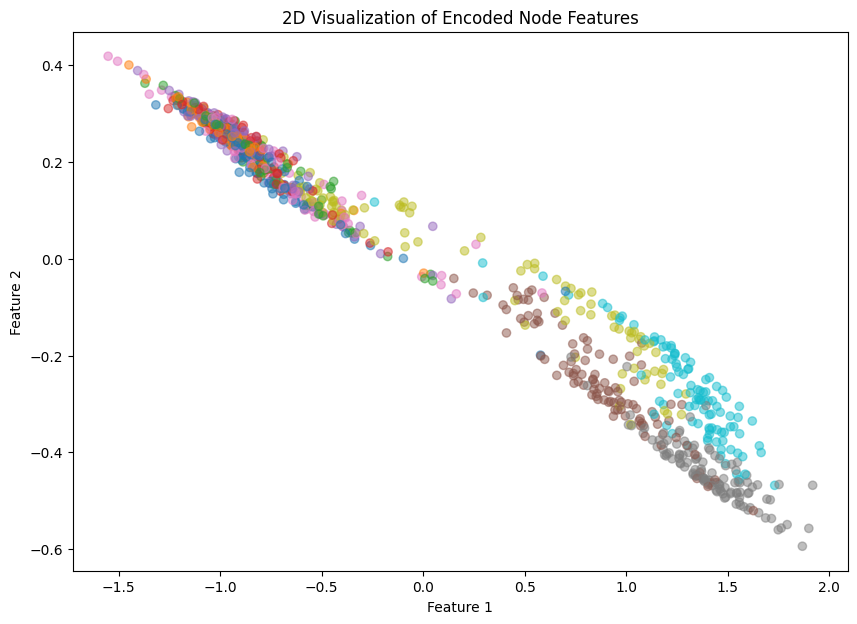

In [30]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 10. Graph AE with residual connection
Three GCNConv layers with a residual connection.

## 

In [31]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 70000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [32]:
class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)
        
        x = self.conv3(x, edge_index)
        
        x += identity  # Add the input to the output
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ResidualGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.2302932739257812
Epoch: 20, Loss: 1.3532663583755493
Epoch: 30, Loss: 1.2716174125671387
Epoch: 40, Loss: 1.1079273223876953
Epoch: 50, Loss: 1.0835875272750854
Epoch: 60, Loss: 1.0546138286590576
Epoch: 70, Loss: 1.047512173652649
Epoch: 80, Loss: 1.0378217697143555
Epoch: 90, Loss: 1.036523699760437
Epoch: 100, Loss: 1.0364606380462646
Epoch: 110, Loss: 1.0305569171905518
Epoch: 120, Loss: 1.033305287361145
Epoch: 130, Loss: 1.032143235206604
Epoch: 140, Loss: 1.0289748907089233
Epoch: 150, Loss: 1.0267698764801025
Epoch: 160, Loss: 1.024735689163208
Epoch: 170, Loss: 1.0242018699645996
Epoch: 180, Loss: 1.0259535312652588
Epoch: 190, Loss: 1.023287296295166
Epoch: 200, Loss: 1.0228556394577026


## 

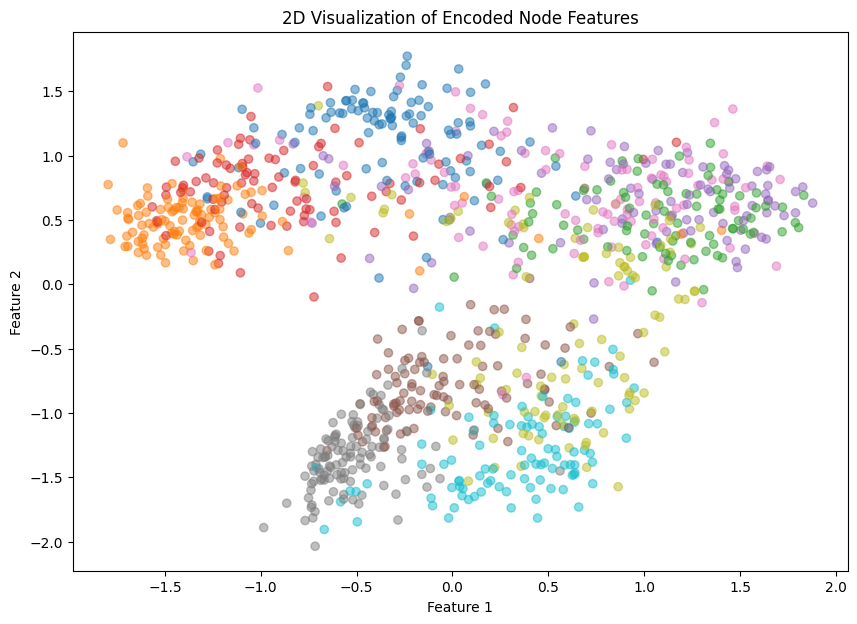

In [33]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 11. Graph AE with attention & normalization
Two GATConv layers with layer normalization.

## 

In [34]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 70000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [35]:
from torch_geometric.nn import GATConv, LayerNorm

class GATWithLayerNormEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=3, dropout_rate=0.6):
        super(GATWithLayerNormEncoder, self).__init__()
        # Define the first layer with multiple heads
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        # For the second layer, we want to reduce the dimension to our desired output dimension
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout_rate)
        # Layer normalization
        self.ln1 = LayerNorm(hidden_channels * heads)
        self.ln2 = LayerNorm(out_channels)

    def forward(self, x, edge_index, dropout_rate=0.6):
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = self.ln1(x)
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(GATWithLayerNormEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

labels = data.y.cpu().numpy()


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.2675411701202393
Epoch: 20, Loss: 1.1745047569274902
Epoch: 30, Loss: 1.127083659172058
Epoch: 40, Loss: 1.1279617547988892
Epoch: 50, Loss: 1.1039118766784668
Epoch: 60, Loss: 1.0748400688171387
Epoch: 70, Loss: 1.060421109199524
Epoch: 80, Loss: 1.0525058507919312
Epoch: 90, Loss: 1.0435667037963867
Epoch: 100, Loss: 1.0436367988586426
Epoch: 110, Loss: 1.0506207942962646
Epoch: 120, Loss: 1.0428096055984497
Epoch: 130, Loss: 1.0394964218139648
Epoch: 140, Loss: 1.0485241413116455
Epoch: 150, Loss: 1.0403447151184082
Epoch: 160, Loss: 1.0374836921691895
Epoch: 170, Loss: 1.038435697555542
Epoch: 180, Loss: 1.0316115617752075
Epoch: 190, Loss: 1.0361248254776
Epoch: 200, Loss: 1.0342448949813843


## 

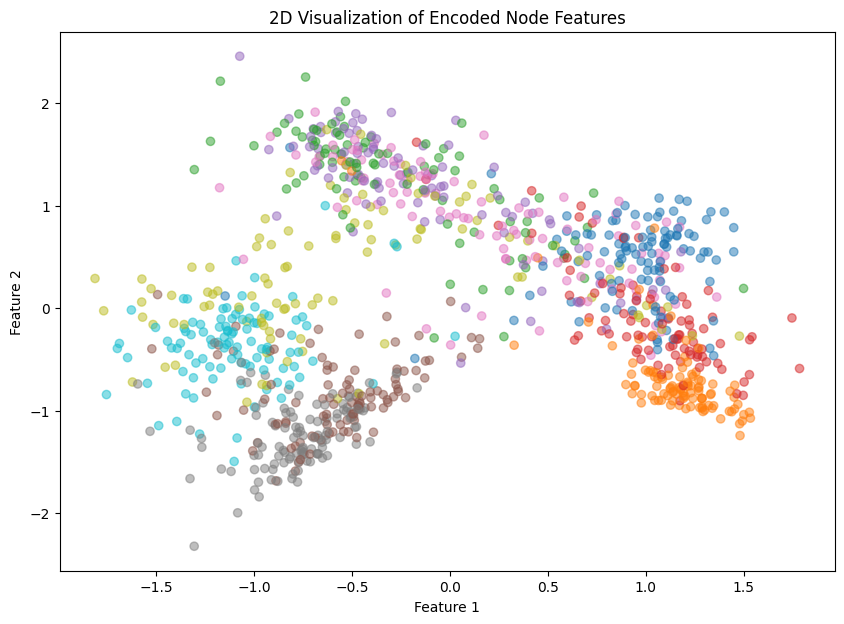

In [36]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')